# **CS5658 Anomaly Detection Homework3 – Industrial Anomaly Detection**

## Due Date:  5/2 23:30

#### MVTec AD dataset
MVTec AD is a benchmark dataset for industrial anomaly detection tasks. It contains 15 industrial product classes with over 5000 images in total. The dataset is designed to perform image anomaly detection and segmentation tasks. There are normal / defect images for each class, with ground truth masks provided for the defect samples.


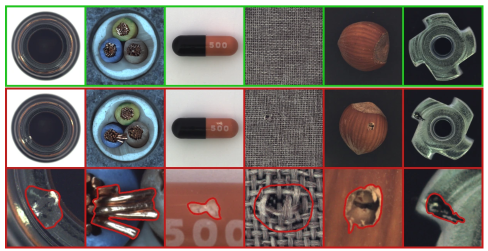

###SimpleNet
SimpleNet is a deep learning model proposed in CVPR 2023. It trains a simple MLP by classifying noisy features from normal features and using it as a discriminator to classify whether a feature is anomaly or not.

Reference: SimpleNet, CVPR 2023

Paper: https://openaccess.thecvf.com/content/CVPR2023/papers/Liu_SimpleNet_A_Simple_Network_for_Image_Anomaly_Detection_and_Localization_CVPR_2023_paper.pdf

Github: https://github.com/DonaldRR/SimpleNet

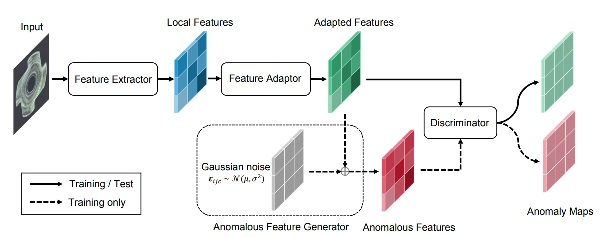


# Problem Setting
In this homework, we will choose two classes in MVTecAD: `metal_nut` and `leather` to perform anomaly detection and segmentation task. You need to implement SimpleNet method by your own, then inference on the two classes. We will use SimpleNet as our architecture, but for the simplicity and training speed, we've made a little adjustments.

* Ignore average pooling in constructing multi-scale feature map
* Use layers [2,3] of WideResNet50
* Epoch reduced from 40 to 20
* Ignore learning rate scheduler
* Discriminator outputs anomaly score instead of normal score

Please implement adaptor and discriminator using the assigned learning rate as follow.
```
adaptor_lr = 1e-3
discriminator_lr = 2e-4
```

Please use **pretrained WideResNet 50** as your feature extractor.

# 1.Download Dataset

In [1]:
!gdown 1vFb_AWIK6nh8BRhRQLM96q2nUqPHsdAR
!unzip mvtec.zip

Downloading...
From (original): https://drive.google.com/uc?id=1vFb_AWIK6nh8BRhRQLM96q2nUqPHsdAR
From (redirected): https://drive.google.com/uc?id=1vFb_AWIK6nh8BRhRQLM96q2nUqPHsdAR&confirm=t&uuid=3cad859a-b748-45e7-89f6-269383a8cf63
To: /content/mvtec.zip
100% 691M/691M [00:03<00:00, 197MB/s]
Archive:  mvtec.zip
   creating: mvtec/
   creating: mvtec/leather/
   creating: mvtec/leather/ground_truth/
   creating: mvtec/leather/ground_truth/color/
  inflating: mvtec/leather/ground_truth/color/000_mask.png  
  inflating: mvtec/leather/ground_truth/color/001_mask.png  
  inflating: mvtec/leather/ground_truth/color/002_mask.png  
  inflating: mvtec/leather/ground_truth/color/003_mask.png  
  inflating: mvtec/leather/ground_truth/color/004_mask.png  
  inflating: mvtec/leather/ground_truth/color/005_mask.png  
  inflating: mvtec/leather/ground_truth/color/006_mask.png  
  inflating: mvtec/leather/ground_truth/color/007_mask.png  
  inflating: mvtec/leather/ground_truth/color/008_mask.png  
 

# 2.Prepare Environment

1.Install needed modules

In [2]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 824.0 kB/s eta 0:00:00


2.Import needed modules and set random seed to ensure that results
are consistent every time executed.

In [3]:
from torchvision.models import wide_resnet50_2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import numpy as np
import random
from PIL import Image
import torch
import torch.nn as nn
from einops import rearrange
#from tqdm.notebook import tqdm
import os
from sklearn.preprocessing import minmax_scale

# adding library
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as AUC
from sklearn.metrics import RocCurveDisplay

%matplotlib inline
import matplotlib.pyplot as plt

#########################################
# prepare environment
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

seed_everything(9999)

# 3.Prepare Dataset

In [4]:
#######################################
# prepare dataset
class MVTecDataset(Dataset):
    def __init__(self, mvtec_folder_path='./mvtec', class_name='leather', is_train=True,
                 few_shot=16,resize=256):
        self.class_name = class_name
        self.is_train = is_train
        self.resize = resize
        self.mvtec_folder_path = mvtec_folder_path
        self.few_shot = few_shot
        # set transforms
        self.transform_x = T.Compose([T.Resize(resize,interpolation=T.InterpolationMode.BILINEAR),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])
        self.transform_mask = T.Compose([T.Resize(resize, interpolation=T.InterpolationMode.NEAREST),
                                         T.ToTensor()])
        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()
        phase = 'training' if self.is_train else 'testing'
        print(f"{self.class_name} {phase} dataset created, consists of {len(self.x)} images")


    def __getitem__(self, idx):
        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]
        return x, y, mask

    def __len__(self):
        return len(self.x)

    def load_dataset_folder(self):
        phase = 'train' if self.is_train else 'test'
        x, y, mask = [], [], []
        img_dir = os.path.join(self.mvtec_folder_path, self.class_name, phase)
        gt_dir = os.path.join(self.mvtec_folder_path, self.class_name, 'ground_truth')
        img_types = sorted(os.listdir(img_dir))
        for img_type in img_types:
            # load images
            img_type_dir = os.path.join(img_dir, img_type)
            if not os.path.isdir(img_type_dir):
                continue
            img_fpath_list = sorted([os.path.join(img_type_dir, f)
                                     for f in os.listdir(img_type_dir)
                                     if f.endswith('.png')])
            x.extend(img_fpath_list)
            # load gt labels
            if img_type == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, img_type)
                img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
                gt_fpath_list = [os.path.join(gt_type_dir, img_fname + '_mask.png')
                                 for img_fname in img_fname_list]
                mask.extend(gt_fpath_list)

        assert len(x) == len(y), 'number of x and y should be same'

        if self.few_shot is not None and phase=='train':
            # pick images according to few_shot number
            chosen_idx = random.sample(list(range(len(x))),k=self.few_shot)
            x = [x[i] for i in chosen_idx]
            y = [y[i] for i in chosen_idx]
            mask = [mask[i] for i in chosen_idx]

        return [self.transform_x(Image.open(x).convert('RGB')).cuda() for x in list(x)], \
                list(y), \
                [torch.zeros([1, self.resize, self.resize]).cuda() if y==0 else self.transform_mask(Image.open(mask)).cuda() for y,mask in zip(list(y),list(mask))]


# 4.Load & Prepare Feature Extractor

In [5]:

#######################################
# load & prepare model (wide_resnet50_2)
encoder = wide_resnet50_2(pretrained=True, progress=True).cuda()
encoder.eval()
# set hook function to get features
outputs = list()
def hook(module, input, output):
    outputs.append(output)

def get_features(model,img,outputs):
    with torch.no_grad():
            _ = model(img.cuda())
    layer1_feature = outputs[0]
    layer2_feature = outputs[1]
    layer3_feature = outputs[2]
    outputs.clear()
    return [layer1_feature,layer2_feature,layer3_feature]

encoder.layer1.register_forward_hook(hook)
encoder.layer2.register_forward_hook(hook)
encoder.layer3.register_forward_hook(hook)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 153MB/s]


# 5.Define Our Function to Produce Multi-Scale Feature Map (TODO Q1)

## TODO Q1
In this section, you need to produce multi-scale feature map in this function.</br></br>
The procedure is listed below:</br>
1. Choose a size to resize to, for example, size of second layers as our target size.</br>
1. Resize all features to the target size and store them.</br>
1. Concatenate them all together and return the result.</br>

You need to finish the step2 above, that is, resize `features[i]` to the target size and assign to `temp_feature`.</br>
For example, if the `target_size` is 32, and `features[i]` have size `(batch, channel, width, height)`, the `temp_feature` should have size `(batch, channel, 32, 32)`




In [6]:
import torch.nn.functional as F
#######################################
# produce multi-scale feature
def concat_feature(features,use_layers=None):
    use_layers = [i-1 for i in use_layers]
    # determine resize to which feature
    target_size = features[1].size()[3] # 32
    resized_feature = list()

    for i in range(len(features)):
        current_size = features[i].size()[3]

        ## TODO ######################################################
        # please calculate the factor or size to resize to
        # use F.interpolate() to resize, set mode to bilinear
        # align_corners to False.
        # For more instruction, please refer to :
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html

        temp_feature = F.interpolate(features[i], size=(target_size, target_size), mode='bilinear', align_corners=False)

        #############################################################
        resized_feature.append(temp_feature)

    return torch.concat([resized_feature[i] for i in use_layers],dim=1)

# 6.Define The Adaptor & Discriminator Of Our Model (TODO Q2)

## TODO Q2
- In this section, you need to design a MLP as the Adaptor.</br>
- The MLP should takes in a tensor with `in_channel` as its channel dimention, and outputs a tensor with `out_channel` as its channel dimention.</br>
- First, implement **the same Adaptor** in SimpleNet paper.
- Second, design your own version of Adaptor with **fewer model parameters to approach the SimpleNet performance**. You need to try **TWO** kinds of model settings. </br>
NOTE: the MLP should not be very complex, you can design a simple one, check the result, and determine if it needs to be more complex. </br></br>

---


**HINT:** A good design should result in Image-AUC=0.95 for leather, Image-AUC=0.95 for metal_nut in Sec.13. your image-AUC of both classes must be greater than 0.8.</br>
***layers = Linear -> LeakyReLU(0.2)***</br>
Things you can change: number of layers, activation function, number of hidden dimension, add Dropout layer, etc. </br>

In [7]:
def init_weight(model):
    if isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)

def aggerator(features):
    batch, channel, h, w = features.shape
    true_feat = torch.zeros((batch*h*w), channel)

    for i in range(channel):
        true_feat[:, i] = torch.flatten(features[:, i, :, :])

    return true_feat #(K, C)

In [8]:
# Implement the same Adaptor in SimpleNet
class Adaptor(nn.Module):
    def __init__(self, in_channel, out_channel, n_layers=1):
        super(Adaptor, self).__init__()

        self.layers = nn.Sequential(nn.Linear(in_channel, out_channel), \
                       nn.LeakyReLU(0.2))

        self.apply(init_weight)

    def forward(self, x):
        feat = aggerator(x).cuda()
        x = self.layers(feat)
        return x

# Implement your own Adaptor with fewer model parameters
## Canceled

# For Todo 7: Without Adaptor
class edited_Adaptor(nn.Module):
    def __init__(self, in_channel, out_channel, n_layers=1):
        super(edited_Adaptor, self).__init__()

        self.layers = nn.Sequential(nn.Linear(in_channel, out_channel), \
                       nn.LeakyReLU(0.2))

        self.apply(init_weight)

    def forward(self, x):
        feat = aggerator(x).cuda()
        ## remove adaptor
        #x = self.layers(feat)
        return feat

- In this section, you need to design a MLP as the Discriminator's body.</br>
- The MLP should takes in a tensor with `in_channel` as its channel dimention, and outputs a tensor with `mid_channel` as its channel dimention.</br>
- First, implement **the same Discriminator** in SimpleNet paper.
- Second, design your own version of Discriminator with **fewer model parameters to approach the SimpleNet performance**. You need to try **TWO** kinds of model settings. </br>
NOTE: the Discriminator should involve at least one BatchNormalization layer.</br></br>

---


**HINT:** A good design should result in Image-AUC=0.95 for leather, Image-AUC=0.95 for metal_nut in Sec.13. It's OK to get lower score than default, but image-AUC of both classes must be greater than 0.8.</br>
***Body = Linear -> BatchNorm1d -> LeakyReLU(0.2)***</br>
Things you can change: number of layers, activation function, number of hidden dimension (`mid_channel`), add Dropout layer, etc. </br>


In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channel, version=0, n_layers=2, mid_channel=None):
        super(Discriminator, self).__init__()

        # Implement the same Discriminator in SimpleNet
        if version == 0:
            mid_channel = int(in_channel//1.5)

            self.layers = nn.Sequential(nn.Linear(in_channel, mid_channel), \
                        nn.BatchNorm1d(mid_channel), \
                        nn.LeakyReLU(0.2), \
                        nn.Linear(mid_channel, 1, bias=False))

        # Implement your own Discriminator with fewer model parameters
        elif version == 1:
            mid_channel = int(in_channel//4)

            self.layers = nn.Sequential(nn.Linear(in_channel, mid_channel), \
                       nn.BatchNorm1d(mid_channel), \
                       nn.LeakyReLU(0.2, inplace=True), \
                       nn.Linear(mid_channel, 1, bias=False))

        elif version == 2:
            mid_channel = int(in_channel//2)

            self.layers = nn.Sequential(nn.Linear(in_channel, mid_channel), \
                       nn.BatchNorm1d(mid_channel), \
                       nn.LeakyReLU(0.2, inplace=True), \
                       nn.Dropout(0.2), \
                       nn.Linear(mid_channel, 1, bias=False))
        self.apply(init_weight)

    def forward(self, x):
        x = self.layers(x)
        return x

# 7.Define Our Whole Model (SimpleNet)

In [10]:
#######################################
# define our model (simplenet)
class Simplenet(nn.Module):
    def __init__(self,in_channel,version=0,adaptor=True,scale=0.05):
        super(Simplenet,self).__init__()

        if adaptor:
            self.adaptor = Adaptor(in_channel,in_channel)
        else:
            self.adaptor = edited_Adaptor(in_channel,in_channel)

        self.discriminator = Discriminator(in_channel, version)

        self.scale=scale

    def add_noise(self,true_feats):
        # print(true_feats.shape) # (K, C)
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, self.scale * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)

        # print(noise.size(), noise_one_hot.size())

        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        true_feats = self.adaptor(x)
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = self.adaptor(x)
        scores = self.discriminator(true_feats)
        return scores,true_feats

# 8.Define The Training Process

In [11]:
def train_one_epoch(encoder,simplenet,adaptor_optim,discriminator_optim,dataset,use_layers,batch_size):
    total_loss = 0
    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)

        scores = simplenet(features)
        true_scores = scores[:features.size()[0]*features.size()[2]*features.size()[3]]
        fake_scores = scores[features.size()[0]*features.size()[2]*features.size()[3]:]

        th = 0.5 #margin
        true_loss = torch.clip(true_scores + th, min=0)
        fake_loss = torch.clip(-fake_scores + th, min=0)

        loss = true_loss.mean() + fake_loss.mean()
        total_loss+=loss

        # clear gradient
        adaptor_optim.zero_grad()
        discriminator_optim.zero_grad()

        # calculate new gradient
        loss.backward()

        # update parameters
        adaptor_optim.step()
        discriminator_optim.step()
    return total_loss

# 9.Define The Testing Process

In [12]:
#######################################
# testing
@torch.no_grad()
def test(encoder,simplenet,dataset,use_layers,batch_size):
    result = dict()
    result['total_scores_pixel'] = list()
    result['total_scores_image'] = list()
    result['total_gt_pixel'] = list()
    result['total_gt_image'] = list()
    result['features_orig'] = list()
    result['features_adapted'] = list()
    result['input_image'] = list()


    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        simplenet.eval()
        # store input image
        result['input_image'].append(x.cpu().detach().numpy())
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        # store features before adaptor
        result['features_orig'].append(rearrange(features,'b c h w -> (b h w) c').cpu().detach().numpy())
        size = features.size()
        scores,true_feats = simplenet.predict(features)
        # store features after adaptor
        result['features_adapted'].append(true_feats.cpu().detach().numpy())

        # calculate and store image-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b (h w)',b=size[0],h=size[3],w=size[2])
        image_score,_ = torch.max(anomaly_score_map,dim=1,keepdim=False)
        result['total_scores_image'].append(image_score.cpu().detach().numpy())

        # calculate and store pixel-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b 1 h w',b=size[0],h=size[3],w=size[2])
        anomaly_score_map = F.interpolate(anomaly_score_map,
                                        size=(x.size()[2],x.size()[3]),
                                        mode="bilinear",
                                        align_corners=False)
        anomaly_score_1d = rearrange(anomaly_score_map,'b c h w -> (b c h w)')
        result['total_scores_pixel'].append(anomaly_score_1d.cpu().detach().numpy())

        # store groundtruth
        mask_1d = rearrange(mask,'b c h w -> (b c h w)')
        result['total_gt_pixel'].append(mask_1d.cpu().detach().numpy())
        result['total_gt_image'].append(y.cpu().detach().numpy())

    # gether all scores and groundtruth
    result['input_image'] = np.concatenate(result['input_image'],axis=0)
    result['total_scores_pixel'] = np.hstack(result['total_scores_pixel'])
    result['total_scores_image'] = np.hstack(result['total_scores_image'])
    result['total_gt_pixel'] = np.hstack(result['total_gt_pixel'])
    result['total_gt_image'] = np.hstack(result['total_gt_image'])

    # gether all extracted features
    result['features_orig'] = np.concatenate(result['features_orig'],axis=0)
    result['features_adapted'] = np.concatenate(result['features_adapted'],axis=0)

    # min-max normalization on scores
    result['total_scores_pixel'] = minmax_scale(result['total_scores_pixel'])
    result['total_scores_image'] = minmax_scale(result['total_scores_image'])

    simplenet.train()
    return result

# 10.Define Functions That Calculate And Show ROC & AUROC (TODO Q3)

## TODO Q3
In this section, you need to define the function to calculate false-positive rate, true-positive rate and area-under ROC by the scores and the groundtruth labels and assign them to `fpr`, `tpr`, `auc` respectively.

In [13]:
def cal_score(label, score):
    fpr, tpr, thresholds = roc_curve(label, score)
    auc = AUC(fpr, tpr)
    return fpr, tpr, auc

# 11.Define Other Utility Functions (if Needed)

In [14]:
label = 'total_gt_image'
score = 'total_scores_image'

# 12.Setup Training Parameters

Setup learning rate, total epoch, layers to used, SimpleNet and optimizer for both class.

In [15]:
# Training parameters
adaptor_lr = 1e-3
discriminator_lr = 2e-4
epochs = 20
batch_size = 4

# Define use_layers
use_layers = [2, 3]

# Create SimpleNet and optimizer for both classes
# next cell

# Create datasets for both classes
leather_train = MVTecDataset(class_name='leather', is_train=True)
leather_test = MVTecDataset(class_name='leather', is_train=False)

metal_nut_train = MVTecDataset(class_name='metal_nut', is_train=True)
metal_nut_test = MVTecDataset(class_name='metal_nut', is_train=False)

leather training dataset created, consists of 16 images
leather testing dataset created, consists of 124 images
metal_nut training dataset created, consists of 16 images
metal_nut testing dataset created, consists of 115 images


In [16]:
# Create SimpleNet and optimizer
def ModelCreation(version, in_channel, adaptor=True, scale=0.05, adaptor_lr=1e-3, discriminator_lr=2e-4):
    SimpleNet = Simplenet(in_channel=in_channel, version=version, adaptor=adaptor, scale=scale).cuda()
    adaptor_optim = torch.optim.AdamW(SimpleNet.adaptor.parameters(), adaptor_lr)
    discriminator_optim = torch.optim.AdamW(SimpleNet.discriminator.parameters(), discriminator_lr)
    return SimpleNet, adaptor_optim, discriminator_optim

# 13.Start Training & Testing (TODO Q4)

## TODO Q4
Write your training / testing code and plot ROC curve.

leather version 0
AUROC Performance: 1.0000


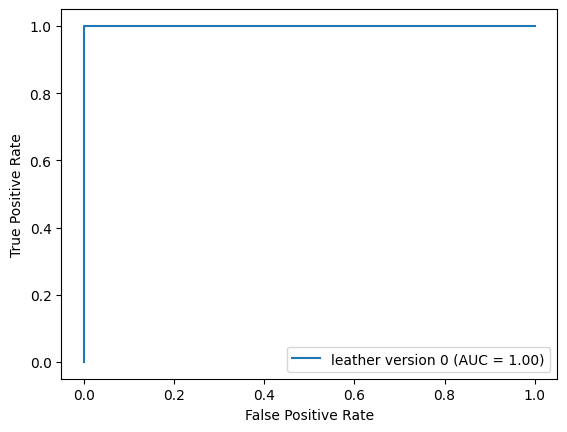

leather version 1
AUROC Performance: 1.0000


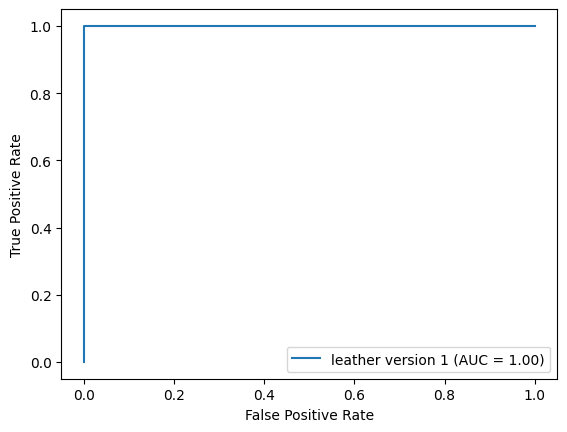

leather version 2
AUROC Performance: 1.0000


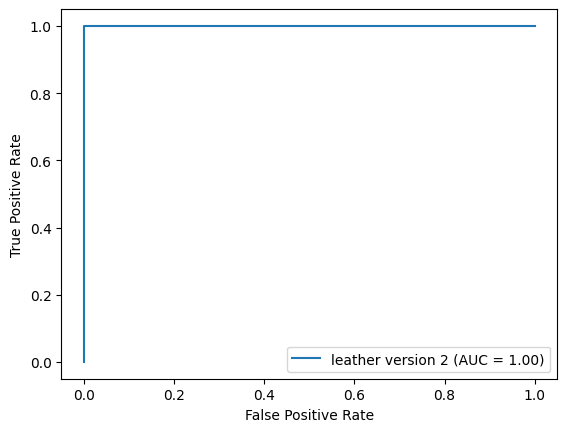

In [17]:
leather_result = []
leather_model_list = []
leather_image = []

for version in range(3):
    Model = ModelCreation(version, 1536)
    print(f'leather version {version}')
    ## training
    for i in range(epochs):
        loss = train_one_epoch(encoder, *Model, leather_train, use_layers, batch_size)
        #print(f"epoch {i}: {loss:.4f}")

    ## testing
    testing_result = test(encoder, Model[0], leather_test, use_layers, batch_size)

    ## For todo6: store result(input_image, gt_pixel, score_pixel)
    store_result = [testing_result['input_image'][0], testing_result['total_gt_pixel'][:256*256], testing_result['total_scores_pixel'][:256*256]]
    leather_image.append(store_result)

    ## plot
    fpr, tpr, auc = cal_score(testing_result[label], testing_result[score])
    print(f'AUROC Performance: {auc:.4f}')
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=f'leather version {version}')
    display.plot()
    plt.show()

    leather_result.append(auc)
    leather_model_list.append(Model[0])


metal nut version 0
AUROC Performance: 0.9580


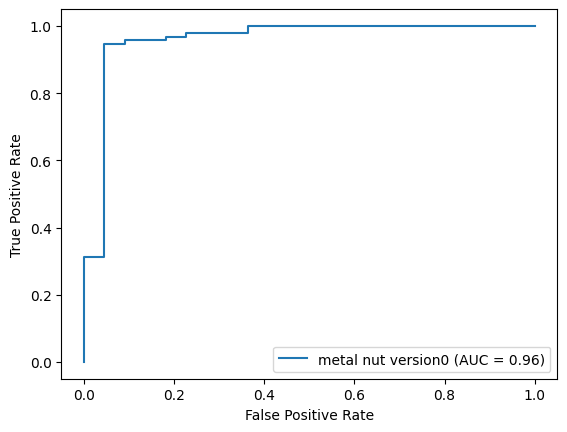

metal nut version 1
AUROC Performance: 0.9624


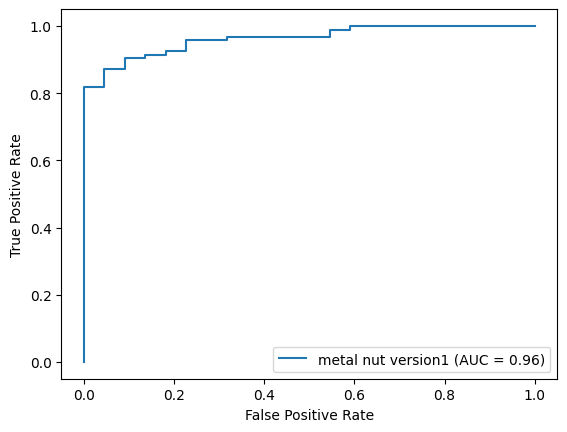

metal nut version 2
AUROC Performance: 0.9848


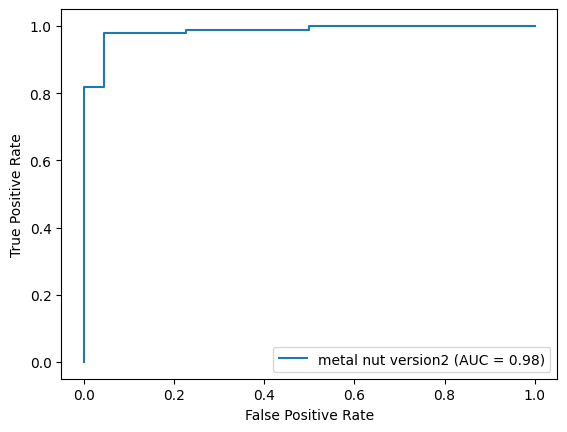

In [18]:
metal_nut_result = []
metal_nut_model_list = []
metal_nut_image = []

for version in range(3):
    Model = ModelCreation(version, 1536)
    print(f'metal nut version {version}')
    ## training
    for i in range(epochs):
        loss = train_one_epoch(encoder, *Model, metal_nut_train, use_layers, batch_size)
        #print(f"epoch {i}: {loss:.4f}")

    ## testing
    testing_result = test(encoder, Model[0], metal_nut_test, use_layers, batch_size)

    ## For todo6: store result(input_image, gt_pixel, score_pixel)
    store_result = [testing_result['input_image'][0], testing_result['total_gt_pixel'][:256*256], testing_result['total_scores_pixel'][:256*256]]
    metal_nut_image.append(store_result)

    ## plot
    fpr, tpr, auc = cal_score(testing_result[label], testing_result[score])
    print(f'AUROC Performance: {auc:.4f}')
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=f'metal nut version{version}')
    display.plot()
    plt.show()

    metal_nut_result.append(auc)
    metal_nut_model_list.append(Model[0])

# 15.Plot Parameters-ROC Figure (TODO Q5)


## TODO Q5
* Try different number of parameters in Adaptor/Discriminator, record the performance.
* Plot the figure with `X-axis=Number of SimpleNet Params`, `Y-axis=AUROC Performance`
* Mark the original SimpleNet as `black point`.
* Mark your models with different number of parameters as `blue points`.


In [19]:
# Use the following code to measure your model parameters
# num_params = sum(p.numel() for p in model.parameters())

def plot(x, y, dataset):
    plt.scatter(x, y, c=['k', 'b', 'b'])
    plt.title(f'Model of {dataset} dataset')
    plt.xlabel('Number of SimpleNet Params')
    plt.ylabel('AUROC Performance')
    plt.yticks(np.arange(0.8, 1.1, step=0.05))
    plt.xticks(np.arange(2.5e6, 4.2e6, step=2.5e5))
    for i in range(3):
        plt.annotate(f'({x[i]}, {y[i]:.4f})', (x[i], y[i]), xytext=(x[i]-2.5e5,y[i]-0.02), fontsize=8)
        plt.annotate(f'version{i}', (x[i], y[i]), xytext=(x[i]-2.5e4,y[i]+0.015), ha='center',fontsize=8)
    plt.show()
    return

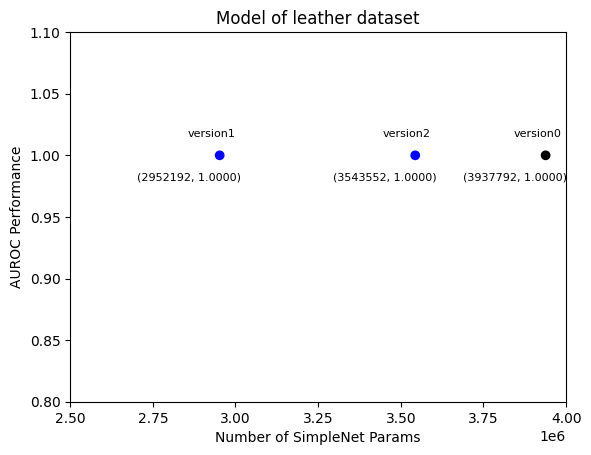

In [20]:
num_params = []
for i, model in enumerate(leather_model_list):
    num_params.append(sum(p.numel() for p in model.parameters()))

plot(num_params, leather_result, 'leather')

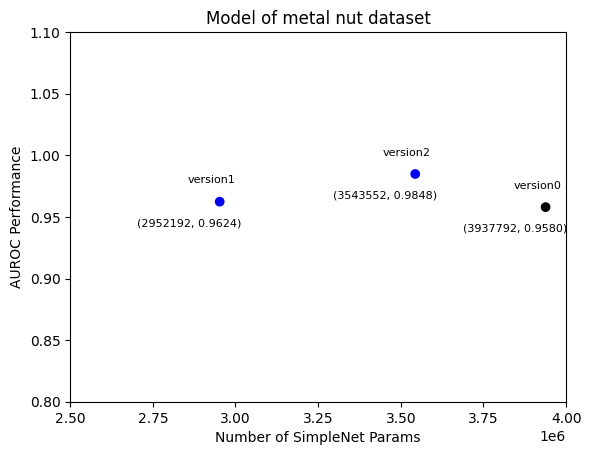

In [21]:
num_params = []
for i, model in enumerate(metal_nut_model_list):
    num_params.append(sum(p.numel() for p in model.parameters()))

plot(num_params, metal_nut_result, 'metal nut')

# 15.Show Testing Results (Input & GT mask & anomaly map) (TODO Q6)

## TODO Q6
In this section, you need to choose a threshold for both class to produce a mask from anomaly map, a pixel with a score higher than the threshold is considered as anomaly region. Threshold should be a number between 0 and 1.

Random choose one inference mask for each class and output results.

(Testing Input / Ground Truth Mask / Predict Mask)

In [22]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

def show(input_image, gt_pixel, scores_pixel, title, ver, threshold=0.5):
    # input_image (3, 256, 256)
    # gt_pixel (256 * 256)
    # scores_pixel (256 * 256)

    plt.figure(figsize=(15, 5))
    plt.suptitle(f'{title} dataset of version {ver}')

    # input_image: inverse normalization
    for i in range(3):
        input_image[i] = (input_image[i] * std[i]) + mean[i]

    image_array = np.transpose(input_image, (1, 2, 0))
    plt.subplot(131)
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Testing Input')
    #plt.show()

    # ground truth: mask
    gt_pixel = np.where(gt_pixel > threshold, 1, 0)
    plt.subplot(132)
    plt.imshow(np.reshape(gt_pixel, (256, 256)), cmap='gray')
    plt.axis('off')
    plt.title('Ground Truth Mask')
    #plt.show()

    # prediction: mask
    scores_pixel = np.where(scores_pixel > threshold, 1, 0)
    plt.subplot(133)
    plt.imshow(np.reshape(scores_pixel, (256, 256)), cmap='gray')
    plt.axis('off')
    plt.title('Predict Mask')

    plt.show()
    return

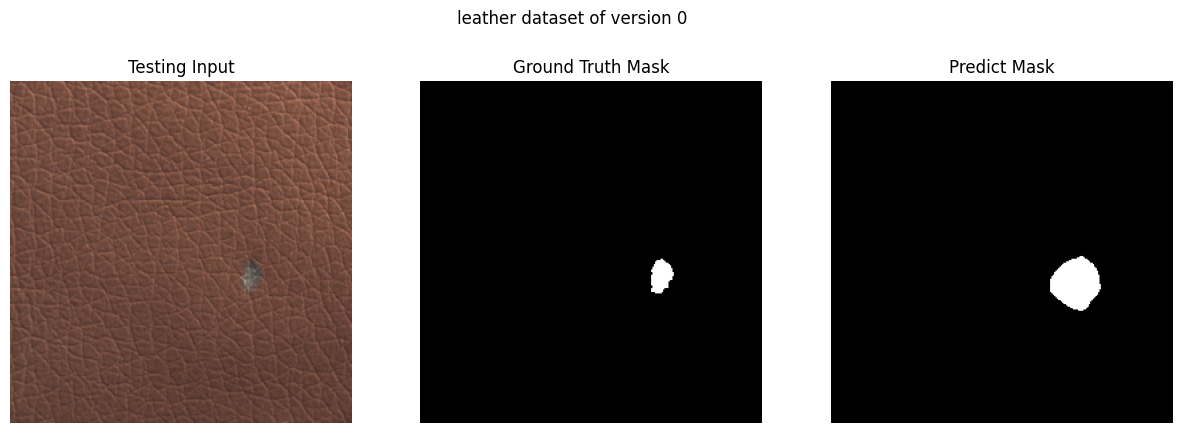

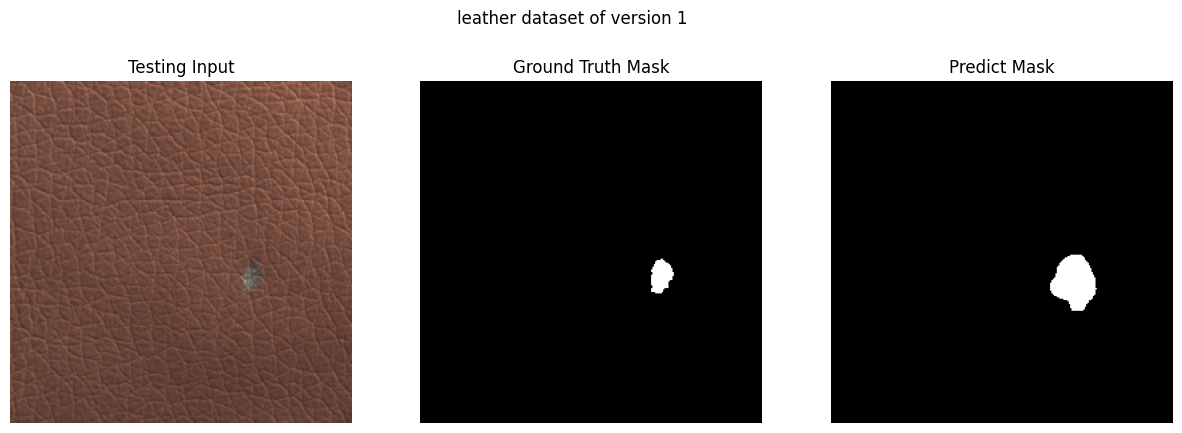

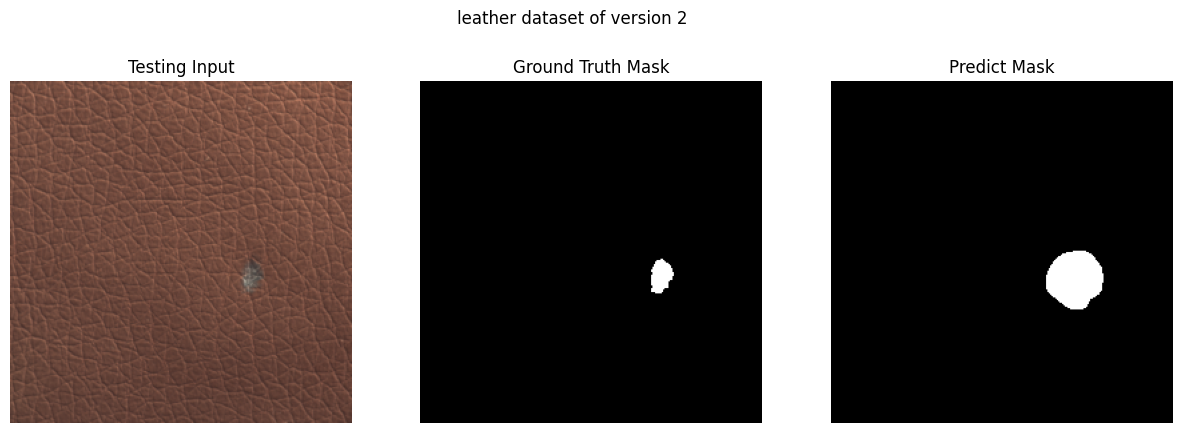

In [23]:
for version in range(3):
    show(*leather_image[version], 'leather', version)

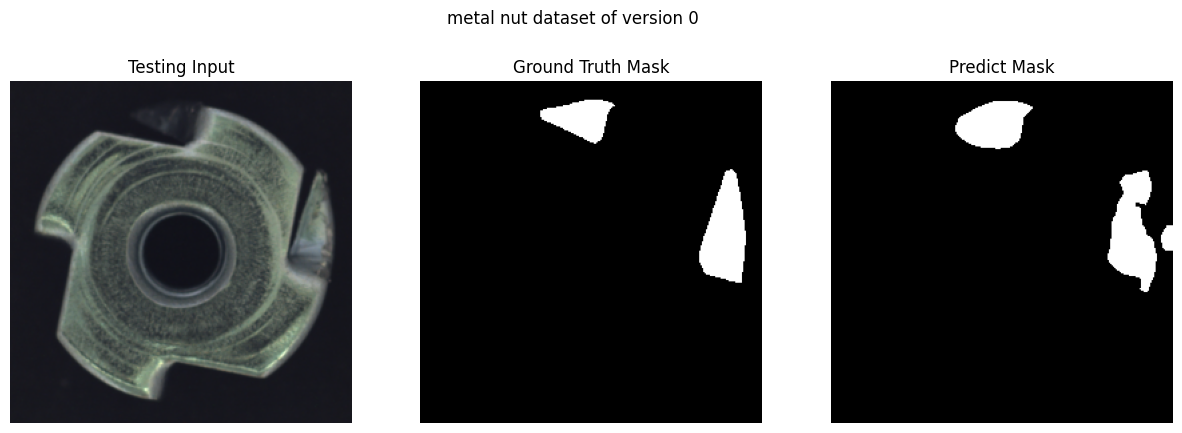

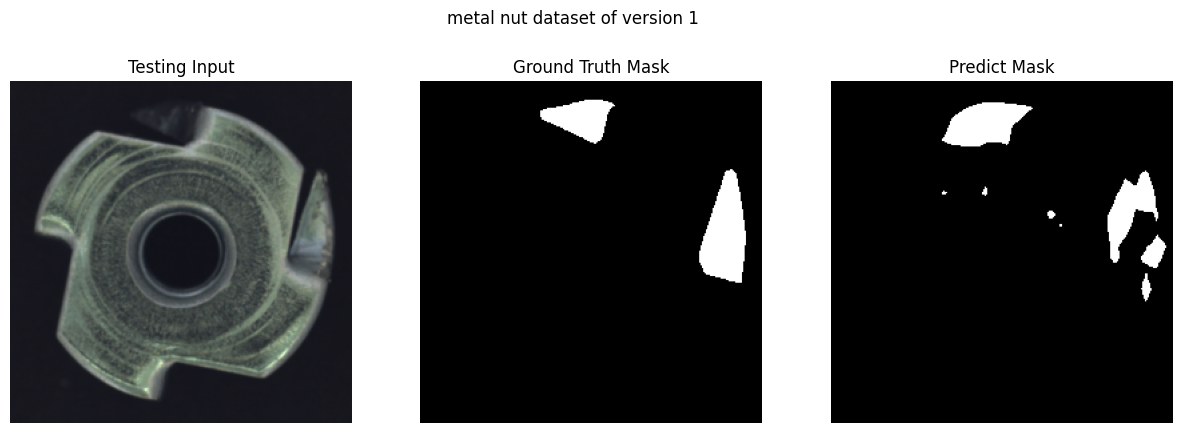

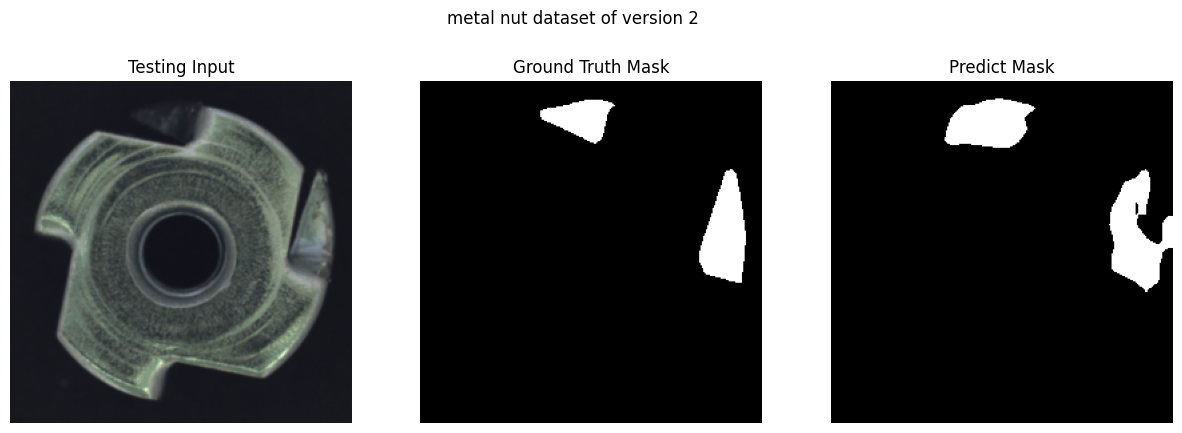

In [24]:
for version in range(3):
    show(*metal_nut_image[version], 'metal nut', version)

# 16.Ablation Study (TODO Q7 / Q8)

## TODO Q7
In this section, you need to conduct experiment with and without using the `adaptor`, and record the performance respectively

In [25]:
Model = ModelCreation(0, 1536, adaptor=False)
## training
for i in range(epochs):
    loss = train_one_epoch(encoder, *Model, leather_train, use_layers, batch_size)
    #print(f"epoch {i}: {loss:.4f}")

## testing
testing_result = test(encoder, Model[0], leather_test, use_layers, batch_size)

## print result
fpr, tpr, auc = cal_score(testing_result[label], testing_result[score])

print('leather dataset')
print(f'AUROC Performance[With adaptor]: {leather_result[0]:.4f}')
print(f'AUROC Performance[Without adaptor]: {auc:.4f}')

leather dataset
AUROC Performance[With adaptor]: 1.0000
AUROC Performance[Without adaptor]: 1.0000


In [26]:
Model = ModelCreation(0, 1536, adaptor=False)
## training
for i in range(epochs):
    loss = train_one_epoch(encoder, *Model, metal_nut_train, use_layers, batch_size)
    #print(f"epoch {i}: {loss:.4f}")

## testing
testing_result = test(encoder, Model[0], metal_nut_test, use_layers, batch_size)

## print result
fpr, tpr, auc = cal_score(testing_result[label], testing_result[score])

print('metal nut dataset')
print(f'AUROC Performance[With adaptor]: {metal_nut_result[0]:.4f}')
print(f'AUROC Performance[Without adaptor]: {auc:.4f}')

metal nut dataset
AUROC Performance[With adaptor]: 0.9580
AUROC Performance[Without adaptor]: 0.9819


## TODO Q8
In this section, you need to conduct experiment with `different scales of the Gaussian noises`. Find the best scale of the noise according to the AUROC performance.

In [27]:
scale_list = [0.02, 0.05, 0.08]
def plot0(x, y, dataset):
    plt.scatter(x, y, c='b')
    best_scale = x[y.index(max(y))]
    plt.title(f'{dataset} dataset\n best scales of Gaussian Noises = {best_scale}')
    plt.xlabel('scales of Gaussian Noises')
    plt.ylabel('AUROC Performance')
    plt.yticks(np.arange(0, 1.2, step=0.1))
    plt.xticks(np.arange(0, 0.12, step=0.02))
    for i in range(3):
        plt.annotate(f'({x[i]}, {y[i]:.4f})', (x[i], y[i]), xytext=(x[i]-7e-3,y[i]-0.1), fontsize=8)
    plt.show()
    return

In [28]:
leather_result = []

for s in scale_list:
    Model = ModelCreation(0, 1536, scale=s)
    ## training
    for i in range(epochs):
        loss = train_one_epoch(encoder, *Model, leather_train, use_layers, batch_size)
        # print(f"epoch {i}: {loss:.4f}")

    ## testing
    testing_result = test(encoder, Model[0], leather_test, use_layers, batch_size)

    ## plot
    fpr, tpr, auc = cal_score(testing_result[label], testing_result[score])
    leather_result.append(auc)

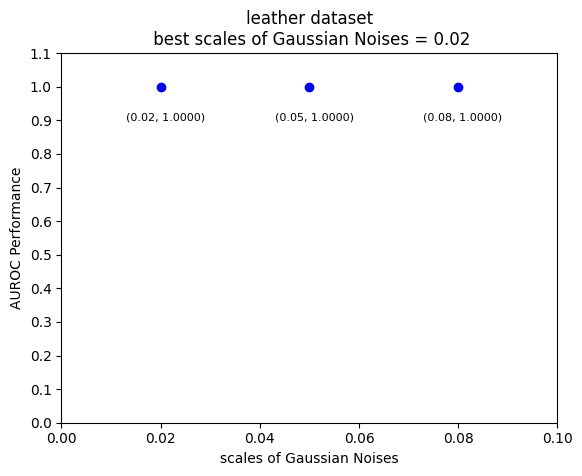

In [29]:
plot0(scale_list, leather_result, 'leather')

In [30]:
metal_nut_result = []

for s in scale_list:
    Model = ModelCreation(0, 1536, scale=s)
    ## training
    for i in range(epochs):
        loss = train_one_epoch(encoder, *Model, metal_nut_train, use_layers, batch_size)
        #print(f"epoch {i}: {loss:.4f}")

    ## testing
    testing_result = test(encoder, Model[0], metal_nut_test, use_layers, batch_size)

    ## plot
    fpr, tpr, auc = cal_score(testing_result[label], testing_result[score])
    metal_nut_result.append(auc)

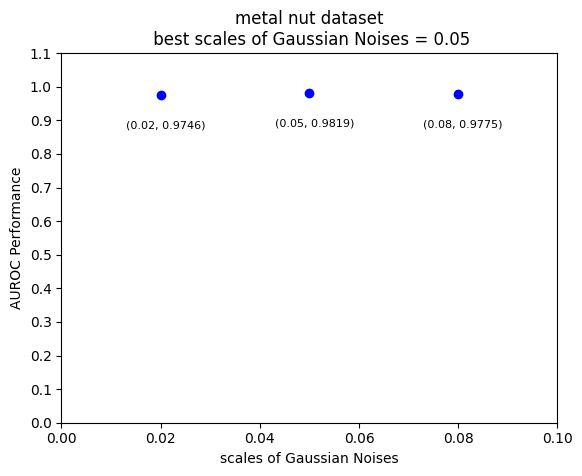

In [31]:
plot0(scale_list, metal_nut_result, 'metal nut')

# 17.Report (TODO Q9)

Write your observations on the two classes, for example:</br>
Based on the observation, which class is more difficult and why?

### Observation
Based on the obsevation, the class of metal nut is more difficult because the converage in training process is more challenging on class of metal nut. I guess that there are two possible reasons:
1. The images of leather have more uniform textures and color compared to the various surface textures of metal nuts, which can make distinguishing anomalies easier.
2. The images of leather are generally less complex on the structure and anomaly variability compared to objects of metal nuts, which can make anomaly detection based on shape deviations easier.